# Imports

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.callbacks import ModelCheckpoint
import h5py

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [3]:
# Load in the csv data
reddit_train_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_train.csv", index_col=0)
reddit_test_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_dev.csv", index_col=0)

# Data setup

Max number of words per post: 78

Getting x_train, y_train, x_test, and y_test...
102991 train sequences
9353 test sequences
----------------------------


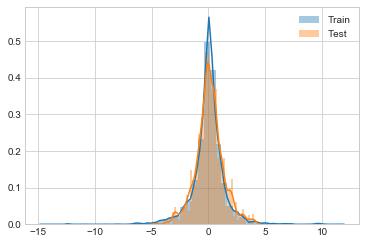

In [4]:
# Determine max post length
max_words_train = get_max_words(reddit_train_df.title.values)
max_words_test = get_max_words(reddit_test_df.title.values)
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Label and title columns in datasets
LABEL_1HR, LABEL_2HR, LABEL_6HR, LABEL_12HR, LABEL_24HR = \
    '1hr_change', '2hr_change', '6hr_change', '12hr_change', '24hr_change'
TEXT_COL = 'title'

# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr) = \
    reddit_train_df[TEXT_COL].values, reddit_train_df[LABEL_1HR], reddit_train_df[LABEL_2HR], \
    reddit_train_df[LABEL_6HR], reddit_train_df[LABEL_12HR], reddit_train_df[LABEL_24HR]

m_train = x_train.shape[0]
y_train_1hr = y_train_1hr.values.reshape((m_train, 1))
y_train_2hr = y_train_2hr.values.reshape((m_train, 1))
y_train_6hr = y_train_6hr.values.reshape((m_train, 1))
y_train_12hr = y_train_12hr.values.reshape((m_train, 1))
y_train_24hr = y_train_24hr.values.reshape((m_train, 1))
    
(x_test, y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr) = \
    reddit_test_df[TEXT_COL].values, reddit_test_df[LABEL_1HR], reddit_test_df[LABEL_2HR], \
    reddit_test_df[LABEL_6HR], reddit_test_df[LABEL_12HR], reddit_test_df[LABEL_24HR]

m_test = x_test.shape[0]
y_test_1hr = y_test_1hr.values.reshape((m_test, 1))
y_test_2hr = y_test_2hr.values.reshape((m_test, 1))
y_test_6hr = y_test_6hr.values.reshape((m_test, 1))
y_test_12hr = y_test_12hr.values.reshape((m_test, 1))
y_test_24hr = y_test_24hr.values.reshape((m_test, 1)) 

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(reddit_train_df[LABEL_1HR].values, label='Train')
sns.distplot(reddit_test_df[LABEL_1HR].values, label='Test')
plt.legend()

# Model setup (part 1/3)

In [5]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
num_epochs = 5 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (102991, 78)
x_test shape: (9353, 78)


# Model setup (part 2/3)

In [6]:
# Build embedding layer using word2vec
EMBEDDING_FILE = "../../data/embeddings/GoogleNews-vectors-negative300.bin"
EMBEDDING_DIM = 300
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False) 

# Model setup (part 3/3)

In [7]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model (attempt 1 - didn't work)
#X = LSTM(128, return_sequences=True)(embeddings)
#X = Dropout(0.5)(X)
#X = LSTM(128, return_sequences=False)(X)
#X = Dropout(0.5)(X)
#X = Dense(1, activation='sigmoid')(X)

# Construct the model (attempt 1 - didn't work)
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(5)(X)

# Select y labels
y_train = np.concatenate((y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr), axis=1)
y_test = np.concatenate((y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr), axis=1)

# Run BTC for 5 epochs

In [ ]:
# Define the BTC model
model = Model(inputs=sequence_input, outputs=X)

# Compile the BTC model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Setup model checkpoint
checkpoint_5 = ModelCheckpoint("checkpoints/reddit-5epochs.hdf5")

# Run the BTC model
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_5])

score, acc = model_btc.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run BTC model for 15 more epochs

In [18]:
# Setup model checkpoints\n",
checkpoint_10 = ModelCheckpoint("checkpoints/reddit-10epochs.hdf5")
checkpoint_15 = ModelCheckpoint("checkpoints/reddit-15epochs.hdf5")
checkpoint_20 = ModelCheckpoint("checkpoints/reddit-20epochs.hdf5")

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_10])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_15])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_20])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


9353/9353 [==============================] - 8s 892us/step
Test score: 2.0105437362759964
Test accuracy: 0.000748422985011647
Train on 102991 samples, validate on 9353 samples
Epoch 1/10
102991/102991 [==============================] - 286s 3ms/step - loss: 1.3101 - acc: 0.0011 - val_loss: 2.0688 - val_acc: 6.4151e-04
Epoch 2/10
102991/102991 [==============================] - 289s 3ms/step - loss: 1.1804 - acc: 0.0011 - val_loss: 2.1797 - val_acc: 5.3459e-04
Epoch 3/10
102991/102991 [==============================] - 291s 3ms/step - loss: 1.0664 - acc: 0.0011 - val_loss: 2.1731 - val_acc: 5.3459e-04
Epoch 4/10
102991/102991 [==============================] - 290s 3ms/step - loss: 0.9696 - acc: 0.0011 - val_loss: 2.2821 - val_acc: 4.2767e-04
Epoch 5/10
102991/102991 [==============================] - 291s 3ms/step - loss: 0.8832 - acc: 0.0011 - val_loss: 2.4185 - val_acc: 6.4151e-04
Epoch 6/10
102991/102991 [==============================] - 292s 3ms/step - loss: 0.8066 - acc: 0.0011 -

# Load model checkpoints

In [8]:
###################################################################
# After 5 epochs
###################################################################
model_5 = Model(inputs=sequence_input, outputs=X)
model_5.load_weights("checkpoints/reddit-5epochs.hdf5")
model_5.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['accuracy'])
score_5, acc_5 = model_5.evaluate(x_test,
                                  y_test,
                                  batch_size=batch_size)
predictions_5 = model_5.predict(x_test)
print('Test score:', score_5)
print('Test accuracy:', acc_5)
                     
###################################################################
# After 10 epochs
###################################################################
model_10 = Model(inputs=sequence_input, outputs=X)
model_10.load_weights("checkpoints/reddit-10epochs.hdf5")
model_10.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_10, acc_10 = model_10.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_10 = model_10.predict(x_test)
print('Test score:', score_10)
print('Test accuracy:', acc_10)

###################################################################
# After 15 epochs
###################################################################
model_15 = Model(inputs=sequence_input, outputs=X)
model_15.load_weights("checkpoints/reddit-15epochs.hdf5")
model_15.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_15, acc_15 = model_15.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_15 = model_15.predict(x_test)
print('Test score:', score_15)
print('Test accuracy:', acc_15)

###################################################################
# After 20 epochs
###################################################################
model_20 = Model(inputs=sequence_input, outputs=X)
model_20.load_weights("checkpoints/reddit-20epochs.hdf5")
model_20.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_20, acc_20 = model_20.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_20 = model_20.predict(x_test)
print('Test score:', score_20)
print('Test accuracy:', acc_20)

9353/9353 [==============================] - 9s 966us/step
Test score: 11.454025297308688
Test accuracy: 0.32535015505596265
9353/9353 [==============================] - 9s 961us/step
Test score: 14.112859787844622
Test accuracy: 0.3053565700860581
9353/9353 [==============================] - 9s 957us/step
Test score: 16.574149997453823
Test accuracy: 0.28931893511059625
9353/9353 [==============================] - 9s 938us/step
Test score: 18.188835654783336
Test accuracy: 0.29338180263176533


# Run BTC model for 10 more epochs

In [58]:
# Setup model checkpoints
checkpoint_25 = ModelCheckpoint("checkpoints/reddit-25epochs.hdf5")
checkpoint_30 = ModelCheckpoint("checkpoints/reddit-30epochs.hdf5")

# Load model trained for 20 epochs
model_new = Model(inputs=sequence_input, outputs=X)
model_new.load_weights("checkpoints/reddit-20epochs.hdf5")
model_new.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])

# Run the model 5 more epochs
model_new.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_25])
score, acc = model_new.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model_new.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_30])
score, acc = model_new.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 292s 3ms/step - loss: 6.5828 - acc: 0.4546 - val_loss: 17.9481 - val_acc: 0.2896
Epoch 2/5
102991/102991 [==============================] - 296s 3ms/step - loss: 6.3696 - acc: 0.4584 - val_loss: 18.6649 - val_acc: 0.2952
Epoch 3/5
102991/102991 [==============================] - 295s 3ms/step - loss: 6.2003 - acc: 0.4616 - val_loss: 18.9551 - val_acc: 0.2808
Epoch 4/5
102991/102991 [==============================] - 296s 3ms/step - loss: 6.0739 - acc: 0.4632 - val_loss: 18.3648 - val_acc: 0.2976
Epoch 5/5
9353/9353 [==============================] - 9s 993us/step
Test score: 18.862592671652422
Test accuracy: 0.2852560675814612
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 295s 3ms/step - loss: 5.8420 - acc: 0.4673 - val_loss: 18.6201 - val_acc: 0.2964
Epoch 2/5
102991/102991 [==============================] - 297s 3m

# Run BTC model for 20 more epochs

In [99]:
# Setup model checkpoints
checkpoint_35 = ModelCheckpoint("checkpoints/reddit-35epochs.hdf5")
checkpoint_40 = ModelCheckpoint("checkpoints/reddit-40epochs.hdf5")
checkpoint_45 = ModelCheckpoint("checkpoints/reddit-45epochs.hdf5")
checkpoint_50 = ModelCheckpoint("checkpoints/reddit-50epochs.hdf5")

# Load model trained for 30 epochs
model_new2 = Model(inputs=sequence_input, outputs=X)
model_new2.load_weights("checkpoints/reddit-30epochs.hdf5")
model_new2.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['accuracy'])

# Run the model 5 more epochs
model_new2.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_35])
score, acc = model_new2.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model_new2.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_40])
score, acc = model_new2.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model_new2.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_45])
score, acc = model_new2.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model_new2.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_50])
score, acc = model_new2.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 339s 3ms/step - loss: 5.4687 - acc: 0.4725 - val_loss: 19.2884 - val_acc: 0.2887
Epoch 2/5
102991/102991 [==============================] - 315s 3ms/step - loss: 5.3882 - acc: 0.4741 - val_loss: 19.1244 - val_acc: 0.2857
Epoch 3/5
102991/102991 [==============================] - 376s 4ms/step - loss: 5.3073 - acc: 0.4759 - val_loss: 19.1210 - val_acc: 0.2875
Epoch 4/5
102991/102991 [==============================] - 318s 3ms/step - loss: 5.2593 - acc: 0.4770 - val_loss: 19.3124 - val_acc: 0.2851
Epoch 5/5
9353/9353 [==============================] - 9s 990us/step
Test score: 19.199506615057842
Test accuracy: 0.28322463380892776
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 293s 3ms/step - loss: 5.1585 - acc: 0.4796 - val_loss: 19.2978 - val_acc: 0.2877
Epoch 2/5
102991/102991 [==============================] - 299s 3

# Load model checkpoints

In [9]:
###################################################################
# After 25 epochs
###################################################################
model_25 = Model(inputs=sequence_input, outputs=X)
model_25.load_weights("checkpoints/reddit-25epochs.hdf5")
model_25.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_25, acc_25 = model_25.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_25 = model_25.predict(x_test)
print('Test score:', score_25)
print('Test accuracy:', acc_25)
                     
###################################################################
# After 30 epochs
###################################################################
model_30 = Model(inputs=sequence_input, outputs=X)
model_30.load_weights("checkpoints/reddit-30epochs.hdf5")
model_30.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_30, acc_30 = model_30.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_30 = model_30.predict(x_test)
print('Test score:', score_30)
print('Test accuracy:', acc_30)

###################################################################
# After 35 epochs
###################################################################
model_35 = Model(inputs=sequence_input, outputs=X)
model_35.load_weights("checkpoints/reddit-35epochs.hdf5")
model_35.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_35, acc_35 = model_35.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_35 = model_35.predict(x_test)
print('Test score:', score_35)
print('Test accuracy:', acc_35)

###################################################################
# After 40 epochs
###################################################################
model_40 = Model(inputs=sequence_input, outputs=X)
model_40.load_weights("checkpoints/reddit-40epochs.hdf5")
model_40.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_40, acc_40 = model_40.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_40 = model_40.predict(x_test)
print('Test score:', score_40)
print('Test accuracy:', acc_40)

###################################################################
# After 45 epochs
###################################################################
model_45 = Model(inputs=sequence_input, outputs=X)
model_45.load_weights("checkpoints/reddit-45epochs.hdf5")
model_45.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_45, acc_45 = model_45.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_45 = model_45.predict(x_test)
print('Test score:', score_45)
print('Test accuracy:', acc_45)

###################################################################
# After 50 epochs
###################################################################
model_50 = Model(inputs=sequence_input, outputs=X)
model_50.load_weights("checkpoints/reddit-50epochs.hdf5")
model_50.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_50, acc_50 = model_50.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_50 = model_50.predict(x_test)
print('Test score:', score_50)
print('Test accuracy:', acc_50)

9353/9353 [==============================] - 9s 920us/step
Test score: 18.862592671652422
Test accuracy: 0.2852560675814612
9353/9353 [==============================] - 9s 927us/step
Test score: 19.235495849661582
Test accuracy: 0.28653907837216946
9353/9353 [==============================] - 9s 937us/step
Test score: 19.199506615057842
Test accuracy: 0.28322463380892776
9353/9353 [==============================] - 9s 944us/step
Test score: 19.717947026414564
Test accuracy: 0.2780925906221968
9353/9353 [==============================] - 9s 925us/step
Test score: 19.948669520467536
Test accuracy: 0.2791617662877587
9353/9353 [==============================] - 8s 903us/step
Test score: 19.720371447717852
Test accuracy: 0.27830642575530923


# Evaluate the results

### First, organize predictions from each number of epochs trained and print summary

In [10]:
###############################################################
# 1/2: CHANGE if more epochs added
###############################################################

# To iterate through training epochs
epochs = ['05 epochs', '10 epochs', '15 epochs', '20 epochs', \
          '25 epochs', '30 epochs', '35 epochs', '40 epochs', \
          '45 epochs', '50 epochs']

# Object 1: To zip all dfs together later
all_dfs = (reddit_test_df.values, \
           predictions_5, \
           predictions_10, \
           predictions_15, \
           predictions_20, \
           predictions_25, \
           predictions_30, \
           predictions_35, \
           predictions_40, \
           predictions_45, \
           predictions_50)

# Object 2: To print below
all_predictions = [('AFTER 5 EPOCHS TRAINING', predictions_5),
                   ('AFTER 10 EPOCHS TRAINING', predictions_10),
                   ('AFTER 15 EPOCHS TRAINING', predictions_15),
                   ('AFTER 20 EPOCHS TRAINING', predictions_20),
                   ('AFTER 25 EPOCHS TRAINING', predictions_25),
                   ('AFTER 30 EPOCHS TRAINING', predictions_30), 
                   ('AFTER 35 EPOCHS TRAINING', predictions_35), 
                   ('AFTER 40 EPOCHS TRAINING', predictions_40), 
                   ('AFTER 45 EPOCHS TRAINING', predictions_45), 
                   ('AFTER 50 EPOCHS TRAINING', predictions_50)]

###############################################################
# 2/2: DON'T CHANGE if more epochs added
###############################################################

# Loop through each set and print summary\n",
for description, prediction in all_predictions:
    pred_1hr, summary_1hr = prediction[:,0], pd.Series(np.squeeze(prediction[:,0])).describe()
    pred_2hr, summary_2hr = prediction[:,1], pd.Series(np.squeeze(prediction[:,1])).describe()
    pred_6hr, summary_6hr = prediction[:,2], pd.Series(np.squeeze(prediction[:,2])).describe()
    pred_12hr, summary_12hr = prediction[:,3], pd.Series(np.squeeze(prediction[:,3])).describe()
    pred_24hr, summary_24hr = prediction[:,4], pd.Series(np.squeeze(prediction[:,4])).describe()

    print('\n%s' % description)
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_1hr['mean'], summary_1hr['min'], summary_1hr['25%'], summary_1hr['75%'], summary_1hr['max']))
    print('[+02 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_2hr['mean'], summary_2hr['min'], summary_2hr['25%'], summary_2hr['75%'], summary_2hr['max']))
    print('[+06 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_6hr['mean'], summary_6hr['min'], summary_6hr['25%'], summary_6hr['75%'], summary_6hr['max']))
    print('[+12 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_12hr['mean'], summary_12hr['min'], summary_12hr['25%'], summary_12hr['75%'], summary_12hr['max']))
    print('[+24 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_24hr['mean'], summary_24hr['min'], summary_24hr['25%'], summary_24hr['75%'], summary_24hr['max']))


AFTER 5 EPOCHS TRAINING
[+01 hr]	Mean: 0.0228	Min: -0.9305	25%: -0.0631	75%: 0.1112	Max: 0.9399
[+02 hr]	Mean: 0.0195	Min: -1.5050	25%: -0.1222	75%: 0.1651	Max: 1.8022
[+06 hr]	Mean: 0.1159	Min: -4.7486	25%: -0.2228	75%: 0.4615	Max: 4.9317
[+12 hr]	Mean: 0.2400	Min: -6.5284	25%: -0.2652	75%: 0.7602	Max: 7.4593
[+24 hr]	Mean: 0.4623	Min: -8.7002	25%: -0.3023	75%: 1.2281	Max: 9.2941

AFTER 10 EPOCHS TRAINING
[+01 hr]	Mean: 0.0260	Min: -1.4070	25%: -0.1506	75%: 0.1927	Max: 2.6116
[+02 hr]	Mean: 0.0589	Min: -2.6301	25%: -0.2617	75%: 0.3645	Max: 5.1058
[+06 hr]	Mean: 0.1841	Min: -8.5745	25%: -0.6412	75%: 0.9734	Max: 13.4106
[+12 hr]	Mean: 0.4062	Min: -12.1255	25%: -0.8545	75%: 1.6208	Max: 20.2075
[+24 hr]	Mean: 0.6845	Min: -15.7347	25%: -1.2130	75%: 2.5223	Max: 28.2422

AFTER 15 EPOCHS TRAINING
[+01 hr]	Mean: 0.0273	Min: -1.6031	25%: -0.1787	75%: 0.2236	Max: 1.9438
[+02 hr]	Mean: 0.0665	Min: -3.1627	25%: -0.3402	75%: 0.4541	Max: 4.4016
[+06 hr]	Mean: 0.1248	Min: -9.1286	25%: -0.9506	75%: 1

### Then, check prediction performance:
- How many of the largest (positive) ACTUAL price changes did we PREDICT correctly
- How many of the largest (negative) ACTUAL price changes did we PREDICT correctly

### Setup

In [12]:
# Prediction times
prediction_times = ['1hr', '2hr', '6hr', '12hr', '24hr']

# Indices of columns in test df and prediction dfs
actual_columns = {'date' : 0, 'title' : 4, '1hr' : 5, '2hr' : 6, '6hr' : 7, '12hr' : 8, '24hr' : 9}
pred_columns = {'1hr' : 0, '2hr' : 1, '6hr' : 2, '12hr' : 3, '24hr' : 4}

# Set cutoffs to only consider largest (positive) price changes
pos_percent = 0.80 # Means will consider top 20%
pos_1hr = pd.Series(np.squeeze(reddit_test_df['1hr_change'])).quantile(pos_percent)
pos_2hr = pd.Series(np.squeeze(reddit_test_df['2hr_change'])).quantile(pos_percent)
pos_6hr = pd.Series(np.squeeze(reddit_test_df['6hr_change'])).quantile(pos_percent)
pos_12hr = pd.Series(np.squeeze(reddit_test_df['12hr_change'])).quantile(pos_percent)
pos_24hr = pd.Series(np.squeeze(reddit_test_df['24hr_change'])).quantile(pos_percent)
pos_cutoffs = {'1hr' : pos_1hr, '2hr' : pos_2hr, '6hr' : pos_6hr, '12hr' : pos_12hr, '24hr' : pos_24hr} 

# Set cutoffs to only consider largest (negative) price changes
neg_percent = 0.20 # Means will consider bottom 20%
neg_1hr = pd.Series(np.squeeze(reddit_test_df['1hr_change'])).quantile(neg_percent)
neg_2hr = pd.Series(np.squeeze(reddit_test_df['2hr_change'])).quantile(neg_percent)
neg_6hr = pd.Series(np.squeeze(reddit_test_df['6hr_change'])).quantile(neg_percent)
neg_12hr = pd.Series(np.squeeze(reddit_test_df['12hr_change'])).quantile(neg_percent)
neg_24hr = pd.Series(np.squeeze(reddit_test_df['24hr_change'])).quantile(neg_percent)
neg_cutoffs = {'1hr' : neg_1hr, '2hr' : neg_2hr, '6hr' : neg_6hr, '12hr' : neg_12hr, '24hr' : neg_24hr} 

# Print
for time in prediction_times:
    print ('[%s] Top cutoff: %.4f, Bottom cutoff: %.4f' % (time, pos_cutoffs[time], neg_cutoffs[time]))

# Initial state of prediction counts
initial_pred_counts = {}
for epoch in epochs:
    initial_pred_counts[epoch] = 0

[1hr] Top cutoff: 0.9864, Bottom cutoff: -0.7630
[2hr] Top cutoff: 1.3951, Bottom cutoff: -1.1409
[6hr] Top cutoff: 2.5950, Bottom cutoff: -1.6548
[12hr] Top cutoff: 3.8299, Bottom cutoff: -2.4704
[24hr] Top cutoff: 6.0746, Bottom cutoff: -2.8883


### Run

In [15]:
###############################################################
# Loop through each prediction time
###############################################################
for time in prediction_times:
       
    # To keep track of (largest positive) counts
    num_actual_above = 0
    num_pred_above, num_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_above, per_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of (largest negative) counts
    num_actual_below = 0
    num_pred_below, num_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_below, per_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of cummulative daily predictions
    total_days = 1
    preds_tally, correct_days, per_correct_days = \
        initial_pred_counts.copy(), initial_pred_counts.copy(), initial_pred_counts.copy()
    current_date = reddit_test_df.values[0][actual_columns['date']].split(' ')[0]
    
    #########################################
    # Loop through each row in actual test df and prediction dfs
    #########################################
    for all_items in zip(*all_dfs):
    
        # Separate 
        i, preds = 0, {}
        actual = all_items[i]
        for epoch in epochs:
            i += 1
            preds[epoch] = all_items[i]
        
        # Check if actual value >= top cutoff
        if actual[actual_columns[time]] >= pos_cutoffs[time]:
            # Increment actual count
            num_actual_above += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] >= pos_cutoffs[time]: num_pred_above[epoch] += 1
                # If prediction positive   
                if preds[epoch][pred_columns[time]] >= 0: num_pred_positive[epoch] += 1
    
        # Check if actual value <= bottom cutoff
        if actual[actual_columns[time]] <= neg_cutoffs[time]:
            # Increment actual count
            num_actual_below += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] <= neg_cutoffs[time]: num_pred_below[epoch] += 1
                # If prediction negative   
                if preds[epoch][pred_columns[time]] <= 0: num_pred_negative[epoch] += 1
    
        # Isolate date of current row
        new_date = actual[actual_columns['date']].split(' ')[0]
     
        # If moved to new date
        if not new_date == current_date:
            # Check prediction tallys vs actual price changes
            for epoch in epochs:
                if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                    correct_days[epoch] += 1
            # Update total day count, reset tally, change current_day
            total_days += 1
            preds_tally = initial_pred_counts.copy()
            current_date = new_date
    
        # Update prediction tallys
        for epoch in epochs:
            preds_tally[epoch] += preds[epoch][pred_columns[time]]
    
    #########################################          
    # Calculate percentage of correct predictions
    #########################################          
    for epoch in epochs:
        per_pred_above[epoch] = (num_pred_above[epoch] / num_actual_above) * 100
        per_pred_positive[epoch] = (num_pred_positive[epoch] / num_actual_above) * 100   
        per_pred_below[epoch] = (num_pred_below[epoch] / num_actual_below) * 100
        per_pred_negative[epoch] = (num_pred_negative[epoch] / num_actual_below) * 100   
        per_correct_days[epoch] = (correct_days[epoch] / total_days) * 100
        
    #########################################          
    # Print results
    #########################################   
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    print ('\nNum ACTUAL in top %d%% (change >= %.2f%%): %d' % \
        (100-int(pos_percent*100), pos_cutoffs[time], num_actual_above))           
    for epoch in epochs:
        print ('[%s train] Above cutoff: %d (%.2f%%), Positive: %d (%.2f%%)' % \
            (epoch, num_pred_above[epoch], per_pred_above[epoch], num_pred_positive[epoch], per_pred_positive[epoch]))
        
    print ('\nNum ACTUAL in bottom %d%% (change <= %.2f%%): %d' % \
        (int(neg_percent*100), neg_cutoffs[time], num_actual_below))           
    for epoch in epochs:
        print ('[%s train] Below cutoff: %d (%.2f%%), Negative: %d (%.2f%%)' % \
            (epoch, num_pred_below[epoch], per_pred_below[epoch], num_pred_negative[epoch], per_pred_negative[epoch]))
    
    print ('\nTotal days in test set: %d' % (total_days))           
    for epoch in epochs:
        print ('[%s train] Correct aggregated predictions: %d days (%.2f%%)' % \
            (epoch, correct_days[epoch], per_correct_days[epoch]))


***** PREDICTIONS +1hr IN FUTURE *****

Num ACTUAL in top 20% (change >= 0.99%): 1881
[05 epochs train] Above cutoff: 0 (0.00%), Positive: 1069 (56.83%)
[10 epochs train] Above cutoff: 8 (0.43%), Positive: 1015 (53.96%)
[15 epochs train] Above cutoff: 15 (0.80%), Positive: 974 (51.78%)
[20 epochs train] Above cutoff: 11 (0.58%), Positive: 879 (46.73%)
[25 epochs train] Above cutoff: 20 (1.06%), Positive: 911 (48.43%)
[30 epochs train] Above cutoff: 16 (0.85%), Positive: 899 (47.79%)
[35 epochs train] Above cutoff: 29 (1.54%), Positive: 940 (49.97%)
[40 epochs train] Above cutoff: 28 (1.49%), Positive: 925 (49.18%)
[45 epochs train] Above cutoff: 35 (1.86%), Positive: 895 (47.58%)
[50 epochs train] Above cutoff: 36 (1.91%), Positive: 930 (49.44%)

Num ACTUAL in bottom 20% (change <= -0.76%): 1881
[05 epochs train] Below cutoff: 0 (0.00%), Negative: 776 (41.25%)
[10 epochs train] Below cutoff: 11 (0.58%), Negative: 889 (47.26%)
[15 epochs train] Below cutoff: 15 (0.80%), Negative: 908 (


***** PREDICTIONS +24hr IN FUTURE *****

Num ACTUAL in top 20% (change >= 6.07%): 1877
[05 epochs train] Above cutoff: 2 (0.11%), Positive: 1267 (67.50%)
[10 epochs train] Above cutoff: 104 (5.54%), Positive: 1095 (58.34%)
[15 epochs train] Above cutoff: 150 (7.99%), Positive: 976 (52.00%)
[20 epochs train] Above cutoff: 199 (10.60%), Positive: 976 (52.00%)
[25 epochs train] Above cutoff: 218 (11.61%), Positive: 948 (50.51%)
[30 epochs train] Above cutoff: 253 (13.48%), Positive: 976 (52.00%)
[35 epochs train] Above cutoff: 253 (13.48%), Positive: 962 (51.25%)
[40 epochs train] Above cutoff: 240 (12.79%), Positive: 948 (50.51%)
[45 epochs train] Above cutoff: 269 (14.33%), Positive: 962 (51.25%)
[50 epochs train] Above cutoff: 241 (12.84%), Positive: 990 (52.74%)

Num ACTUAL in bottom 20% (change <= -2.89%): 1875
[05 epochs train] Below cutoff: 20 (1.07%), Negative: 649 (34.61%)
[10 epochs train] Below cutoff: 187 (9.97%), Negative: 751 (40.05%)
[15 epochs train] Below cutoff: 350 (18